In [5]:
%reset -f
from parflow import Run
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
from utils import init_location, cal_z_locid, cal_velz_loc, \
                  interpolate_vel, data_normalize, To_Tensor
# from parflow.tools.hydrology import calculate_water_table_depth, \
# calculate_overland_flow_grid, calculate_overland_fluxes
# %matplotlib widget

In [6]:
p_start = 35040
t_start = 0 #iteration start
t_end = 50 #iteration end
real_path = 'False'
selectd = np.array([1,19,1,4,1,19])
#0-20,0-5,0-20 because this is actually 0-19,0-4,0-19

npcell = 2  #used for train
testsize = 1  #used for test
npcell = npcell + testsize  #all
# how many particles in a grid cell

interval = 1 #always no gap
step_size = 1 #always one hour

In [7]:
# input model parameters
nx = 20
ny = 5
nz = 20

dx = 5
dy = 0.2
dz = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, \
               0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.1])

boundings = np.array([0., 100., 0., 1., 0., 9.4])

In [8]:
for ii in range(t_start,t_end):
    
    # istept = 1 + ii #current iterate step
    istept = 1

    Vx = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.velx.' \
                                    +str(istept+p_start).zfill(5)+'.pfb'))
    Vy = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.vely.' \
                                    +str(istept+p_start).zfill(5)+'.pfb'))
    Vz = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.velz.' \
                                    +str(istept+p_start).zfill(5)+'.pfb'))
    Saturation = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.satur.' \
                                            +str(istept+p_start).zfill(5)+'.pfb'))
    Porosity = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.porosity.pfb'))
    # print(Vx.shape, Vy.shape, Vz.shape)

    # if real_path == 'False' or (real_path == 'True' and istep == (t_start + 1)):
    if ii == t_start:
        
        #setup initial location
        initx,inity,initz = init_location(npcell,nx,ny,nz,dx,dy,dz)
        # initz[1,0,:,:]

        #cal locid
        Px = np.copy(initx)
        Py = np.copy(inity)
        Pz = np.copy(initz)
        
        print('real_path',real_path)
    
#     if real_path == 'True' and istep != (t_start + 1):
        
#         initx = np.copy(Px)
#         inity = np.copy(Py)
#         initz = np.copy(Pz)
        
#         print('real_path',real_path)

    Plocx = np.floor(Px/dx)
    Plocy = np.floor(Py/dy)
    Plocz = cal_z_locid(npcell,nx,ny,nz,dz,Pz)

    # cal vel loc
    # this can be got by random number directly
    # but for multiple steps, we still need to calculate
    # so we provide the template here
    # we may also calculate it from random number
    # i mean like add the intial fraction with the new_distance/vel
    # but additional other calculation may need

    Clocx = (Px - Plocx*dx)/dx
    Clocy = (Py - Plocy*dy)/dy
    Clocz = cal_velz_loc(npcell,nx,ny,nz,dz,Pz,Plocz)

    Vpx, Vpy, Vpz = interpolate_vel(npcell,nx,ny,nz,Plocx,Plocy,Plocz,Clocx,Clocy,Clocz, \
                                   Vx,Vy,Vz,Saturation,Porosity)

    Px[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Px[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpx[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]
    
    Py[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Py[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpy[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]
    
    Pz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Pz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]

    tt,initx1,inity1,initz1,Px1,Py1,Pz1 = data_normalize(ii,interval,step_size,t_start,t_end, \
                                                   initx,inity,initz,Px,Py,Pz,boundings)

    start_train_new, end_train_new, time_train_new = To_Tensor(0,npcell-testsize, \
               selectd[0],selectd[2],selectd[4],selectd[1],selectd[3],selectd[5], \
                                                initx1,inity1,initz1,Px1,Py1,Pz1,tt)
    start_test_new, end_test_new, time_test_new = To_Tensor(npcell-testsize,npcell, \
               selectd[0],selectd[2],selectd[4],selectd[1],selectd[3],selectd[5], \
                                                initx1,inity1,initz1,Px1,Py1,Pz1,tt)
    # start_train_new, end_train_new, time_train_new = To_Tensor(0,npcell-testsize, \
    #            selectd[0],selectd[2],selectd[4],selectd[1],selectd[3],selectd[5], \
    #                                             initx,inity,initz,Px,Py,Pz,istep)
    # start_test_new, end_test_new, time_test_new = To_Tensor(npcell-testsize,npcell, \
    #            selectd[0],selectd[2],selectd[4],selectd[1],selectd[3],selectd[5], \
    #                                             initx,inity,initz,Px,Py,Pz,istep)
    
    if ii == t_start:
        start_train = start_train_new
        end_train   = end_train_new
        time_train  = time_train_new
        
        start_test  = start_test_new
        end_test    = end_test_new
        time_test   = time_test_new
        
    else:
        
        start_train = torch.cat((start_train, start_train_new),dim=0)
        end_train   = torch.cat((end_train, end_train_new),dim=0)
        time_train  = torch.cat((time_train, time_train_new),dim=0)
        
        start_test  = torch.cat((start_test, start_test_new),dim=0)
        end_test    = torch.cat((end_test, end_test_new),dim=0)
        time_test   = torch.cat((time_test, time_test_new),dim=0)
    

real_path False


In [9]:
print(start_train.shape,start_test.shape,end_train.shape,end_test.shape)

torch.Size([97200, 3]) torch.Size([48600, 3]) torch.Size([97200, 3]) torch.Size([48600, 3])


In [15]:
data_train = TensorDataset(start_train,end_train,time_train)
data_test = TensorDataset(start_test,end_test,time_test)

if real_path == 'True':
    torch.save(data_train,'data_check.pth')  
else:
    torch.save(data_train,'data_train.pth')
    torch.save(data_test,'data_test.pth')

In [18]:
count = 0
for x in data_train:#generator
    count = count + 1
    if count%2000 == 0: 
        print(x)

(tensor([-0.5597, -0.5233, -0.1992]), tensor([-0.5599, -0.5233, -0.1993]), tensor([-0.9800]))
(tensor([-0.0557,  0.1122,  0.5155]), tensor([-0.0557,  0.1122,  0.5150]), tensor([-0.9600]))
(tensor([ 0.4664,  0.5979, -0.7869]), tensor([ 0.4659,  0.5979, -0.7869]), tensor([-0.9200]))
(tensor([-0.9445, -0.4027,  0.0930]), tensor([-0.9449, -0.4027,  0.0990]), tensor([-0.9000]))
(tensor([-0.4353,  0.1789,  0.8366]), tensor([-0.4353,  0.1789,  0.8350]), tensor([-0.8800]))
(tensor([ 0.0068,  0.5647, -0.4016]), tensor([ 0.0060,  0.5647, -0.4015]), tensor([-0.8400]))
(tensor([ 0.5353, -0.9320,  0.4845]), tensor([ 0.5353, -0.9320,  0.4832]), tensor([-0.8200]))
(tensor([-0.8447, -0.1052, -0.8453]), tensor([-0.8459, -0.1052, -0.8447]), tensor([-0.7800]))
(tensor([-0.3329,  0.2365, -0.1465]), tensor([-0.3342,  0.2365, -0.1469]), tensor([-0.7600]))
(tensor([ 0.1135, -0.8359,  0.7521]), tensor([ 0.1134, -0.8359,  0.7484]), tensor([-0.7400]))
(tensor([ 0.6915, -0.5793, -0.5104]), tensor([ 0.6904, -0.57

In [3]:
data_train = torch.load('./data_train.pth')

b = data_train[:][1]
a = b.numpy()
print(a[:10,:])

# b = data_train[:][1]
# c = b.numpy()

# b = data_train[:][2]
# t = b.numpy()
# len(t)

[[0.93481445 0.49021605 0.9976267 ]
 [0.934813   0.49021506 0.9976128 ]
 [0.93481165 0.4902141  0.9975987 ]
 [0.9348102  0.49021313 0.99758464]
 [0.93480885 0.49021214 0.99757046]
 [0.9348075  0.49021116 0.99755615]
 [0.93480605 0.4902102  0.99754184]
 [0.9348047  0.49020922 0.99752736]
 [0.93480325 0.49020824 0.9975129 ]
 [0.9348019  0.49020725 0.9974982 ]]


/tmp/ipykernel_13347/3189349302.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(xline0, yline0, zline0, cmap='r_Blues')


Text(0.5, 0, 'z')

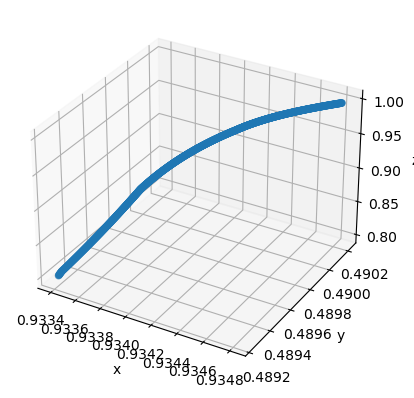

In [7]:
# import time
# fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# for ii in range(600):
# ii =0:10
# xline = c[ii,0]
# yline = c[ii,1]
# zline = c[ii,2]
xline0 = a[0:1000,0]
yline0 = a[0:1000,1]
zline0 = a[0:1000,2]
# tdata = t[0:10]
ax.plot3D(xline0, yline0, zline0, 'gray')
# ax.plot3D(xline0, yline0, zline0, 'blue')
# ax.scatter3D(xline, yline, zline, cmap='r_Blues')
ax.scatter3D(xline0, yline0, zline0, cmap='r_Blues')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# time.sleep(2)
# ax.show()